# Import Packages

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
import numpy as np

# Load Dataset

In [201]:
data = pd.read_csv('train.csv')
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.23
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.09
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.65
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,6.60
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.90


# Data Preprocessing Pipeline
* **Ordinal Feature Encoder**: Convert categorical variables into numerical variables while keeping the order of categories.
* **Label Feature Encoder**: Convert categorical labels into numerical labels.
* **Feature Dropper**: Drops unnecessary features from the dataset.
* **Feature Scaler**: Scales the features to have zero mean and unit variance.
* **KNN Imputer**: Replace missing values using KNN.

In [202]:
class NullsImputer(BaseEstimator, TransformerMixin):

    def __init__(self, n_neighbors=1):
        self.imputer = KNNImputer(n_neighbors=n_neighbors)

    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self

    def transform(self, X):
        X_imputed = self.imputer.transform(X)
        return pd.DataFrame(X_imputed, columns=X.columns, index=X.index) if isinstance(X, pd.DataFrame) else X_imputed

In [203]:
class OrdinalFeatureEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.ordinal_encoder = OrdinalEncoder(
            categories=[
                ['Small', 'Medium', 'High'],
                ['Tier 1', 'Tier 2', 'Tier 3'],
                ['Grocery Store', 'Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3']
            ],
            handle_unknown='use_encoded_value', 
            unknown_value=-2
        )

    def fit(self, X, y=None):
        self.ordinal_encoder.fit(X[['X9', 'X10', 'X11']])
        return self

    def transform(self, X):
        encoded_values = self.ordinal_encoder.transform(X[['X9', 'X10', 'X11']]) + 1
        X[['X9_encoded', 'X10_encoded', 'X11_encoded']] = encoded_values
        X.replace(-1, np.nan, inplace=True)
        return X

In [204]:
class LabelFeatureEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.X3_label_encoder = LabelEncoder()
        self.X5_label_encoder = LabelEncoder()
        self.X7_label_encoder = LabelEncoder()

    def fit(self, X, y=None):
        X3_processed = X['X3'].str.lower().replace({'lf': 'low fat', 'reg': 'regular'})
        self.X3_label_encoder.fit(X3_processed)
        self.X5_label_encoder.fit(X['X5'])
        self.X7_label_encoder.fit(X['X7'])
        return self

    def transform(self, X):
        X['X3'] = X['X3'].str.lower().replace({'lf': 'low fat', 'reg': 'regular'})
        X['X3_encoded'] = self.X3_label_encoder.transform(X['X3'])
        X['X5_encoded'] = self.X5_label_encoder.transform(X['X5'])
        X['X7_encoded'] = self.X7_label_encoder.transform(X['X7'])
        return X

In [205]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(['X1', 'X7', 'X10', 'X11', 'X3', 'X5', 'X9'], axis=1, errors="ignore")

In [206]:
class FeatureScaler(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self
    
    def transform(self, X):
        x_scaled = self.scaler.transform(X)
        return pd.DataFrame(x_scaled, columns=X.columns, index=X.index) if isinstance(X, pd.DataFrame) else x_scaled

In [207]:
pipeline = Pipeline([("OrdinalFeatureEncoder", OrdinalFeatureEncoder()),
                     ("LabelFeatureEncoder", LabelFeatureEncoder()),
                     ("FeatureDropper", FeatureDropper()),
                    #  ("FeatureScaler", FeatureScaler()),
                     ("NullsImputer", NullsImputer())])

# Preprocess the Training Data

In [208]:
X_train = data.drop(['Y'], axis=1)
y_train = data['Y']

pipeline.fit(X_train)

X_train_processed = pipeline.transform(X_train)
X_train_processed

,X2,X4,X6,X8,X9_encoded,X10_encoded,X11_encoded,X3_encoded,X5_encoded,X7_encoded
0,9.300,0.016047,249.8092,1999.0,2.0,1.0,2.0,0.0,4.0,9.0
1,5.920,0.019278,48.2692,2009.0,2.0,3.0,3.0,1.0,14.0,3.0
2,17.500,0.016760,141.6180,1999.0,2.0,1.0,2.0,0.0,10.0,9.0
3,19.200,0.000000,182.0950,1998.0,1.0,3.0,1.0,1.0,6.0,0.0
4,8.930,0.000000,53.8614,1987.0,3.0,3.0,2.0,0.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...
5995,20.600,0.023586,94.7778,2007.0,2.0,2.0,2.0,0.0,6.0,2.0
5996,9.195,0.115064,58.6246,1999.0,2.0,1.0,2.0,0.0,5.0,9.0
5997,10.695,0.057910,60.4536,2002.0,1.0,2.0,2.0,0.0,6.0,7.0
5998,15.750,0.054920,195.8452,2004.0,1.0,2.0,2.0,0.0,0.0,6.0


In [209]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   X2           6000 non-null   float64
 1   X4           6000 non-null   float64
 2   X6           6000 non-null   float64
 3   X8           6000 non-null   float64
 4   X9_encoded   6000 non-null   float64
 5   X10_encoded  6000 non-null   float64
 6   X11_encoded  6000 non-null   float64
 7   X3_encoded   6000 non-null   float64
 8   X5_encoded   6000 non-null   float64
 9   X7_encoded   6000 non-null   float64
dtypes: float64(10)
memory usage: 468.9 KB


# Preprocess the Tesing Data

In [210]:
test_data = pd.read_csv('test.csv')
test_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,FDO37,NaN,Low Fat,0.021273,Breakfast,229.1326,OUT027,1985,Medium,Tier 3,Supermarket Type3
1,FDV13,17.35,Regular,0.027588,Canned,86.1856,OUT013,1987,High,Tier 3,Supermarket Type1
2,FDF52,9.30,Low Fat,0.111782,Frozen Foods,182.3292,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDY11,6.71,Regular,0.029606,Baking Goods,65.4142,OUT049,1999,Medium,Tier 1,Supermarket Type1
4,FDL20,17.10,Low Fat,0.129141,Fruits and Vegetables,109.4886,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [211]:
test_data_processed = pipeline.transform(test_data)
test_data_processed.head()

,X2,X4,X6,X8,X9_encoded,X10_encoded,X11_encoded,X3_encoded,X5_encoded,X7_encoded
0,8.42,0.021273,229.1326,1985.0,2.0,3.0,4.0,0.0,2.0,5.0
1,17.35,0.027588,86.1856,1987.0,3.0,3.0,2.0,1.0,3.0,1.0
2,9.30,0.111782,182.3292,1998.0,1.0,3.0,1.0,0.0,5.0,0.0
3,6.71,0.029606,65.4142,1999.0,2.0,1.0,2.0,1.0,0.0,9.0
4,17.10,0.129141,109.4886,2007.0,2.0,2.0,2.0,0.0,6.0,2.0


# Plot the Correlation Matrix after Preprocessing

In [212]:
X_train_processed['Y'] = data['Y']
X_train_processed.head()

,X2,X4,X6,X8,X9_encoded,X10_encoded,X11_encoded,X3_encoded,X5_encoded,X7_encoded,Y
0,9.30,0.016047,249.8092,1999.0,2.0,1.0,2.0,0.0,4.0,9.0,8.23
1,5.92,0.019278,48.2692,2009.0,2.0,3.0,3.0,1.0,14.0,3.0,6.09
2,17.50,0.016760,141.6180,1999.0,2.0,1.0,2.0,0.0,10.0,9.0,7.65
3,19.20,0.000000,182.0950,1998.0,1.0,3.0,1.0,1.0,6.0,0.0,6.60
4,8.93,0.000000,53.8614,1987.0,3.0,3.0,2.0,0.0,9.0,1.0,6.90


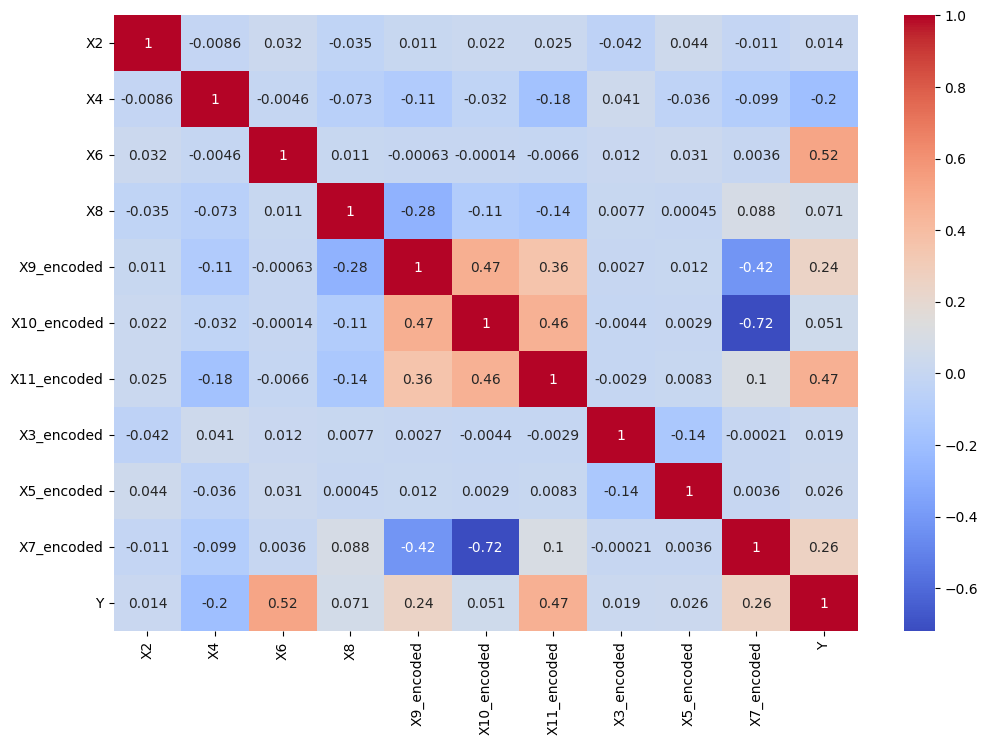

In [213]:
plt.figure(figsize=(12, 8))  # Increase size (width=12, height=8)
sns.heatmap(X_train_processed.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

# Save the Preprocessed Training and Testing Data

In [214]:
X_train_processed.to_csv('new_train.csv', index=False)
test_data_processed.to_csv('new_test.csv', index=False)